# Fourier Transform
Fourier Transform is one of the techniques used to process images. This notebook aims to find out the usage of our Unet model.

In [73]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from google.colab.patches import cv2_imshow
from typing import List

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/MachineLearning/Geospatial_ML

/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML


In [ ]:
! git pull
! git checkout feature/fourier-transform

In [76]:
data_directory = "../data_colab/256_200"

# y_train  = np.load(os.path.join(data_directory, '2022_06_20.npz'))['y_mask']
x_train  = np.load(os.path.join(data_directory, '2022_06_20.npz'))['x_input']

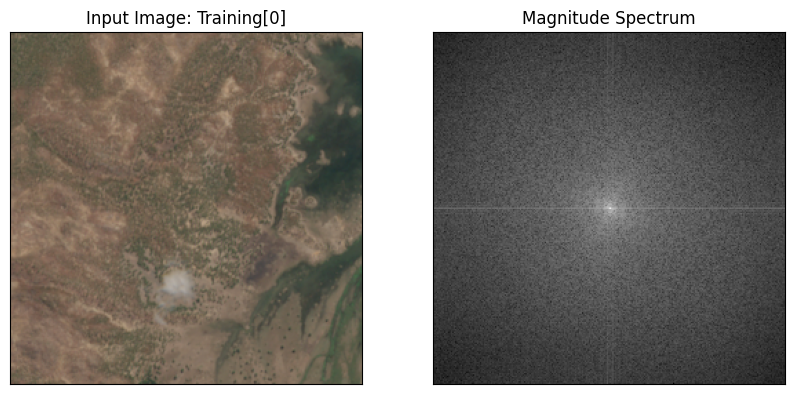

In [41]:
x_train[0]
img = x_train[0, :, :, :3]  # extract the first 3 channels (RGB)
img = cv2.convertScaleAbs(img)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Calculate the magnitude spectrum for each color channel
f_r = np.fft.fft2(img[:,:,0])
f_g = np.fft.fft2(img[:,:,1])
f_b = np.fft.fft2(img[:,:,2])
mag_r = 20*np.log(np.abs(np.fft.fftshift(f_r)))
mag_g = 20*np.log(np.abs(np.fft.fftshift(f_g)))
mag_b = 20*np.log(np.abs(np.fft.fftshift(f_b)))
# Combine the magnitude spectra into a single grayscale image
magnitude_spectrum = cv2.merge((mag_r, mag_g, mag_b))
magnitude_spectrum = np.max(magnitude_spectrum, axis=2)

fig = plt.figure(figsize=(10, 10))
plt.subplot(121),plt.imshow(img)
plt.title('Input Image: Training[0]'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

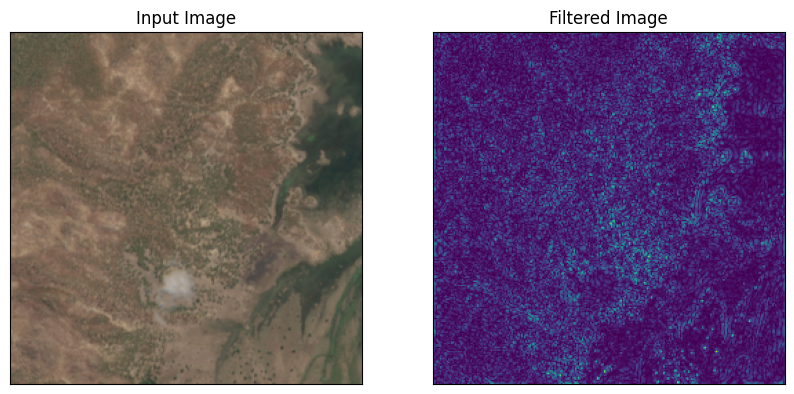

In [42]:
grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Apply Fourier transform to image
f = np.fft.fft2(grey_img)

# Shift zero frequency component to center
fshift = np.fft.fftshift(f)

# Set low frequency coefficients to zero
rows, cols = grey_img.shape
crow, ccol = rows/2, cols/2
crow = int(crow)
ccol = int(ccol)
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0

# Shift zero frequency component back to origin
f_ishift = np.fft.ifftshift(fshift)

# Invert Fourier transform to obtain filtered image
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
img_back = img_back.astype(np.uint8)

# Display input image and filtered image
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1)
plt.imshow(img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

fig.add_subplot(1,2,2)
plt.imshow(img_back)
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()

### Transform Images into Magnitude Spectrum
The Magnitude Spectrum refers to the size of amplitude of each frequency components.

For visualisation purposes, it is often useful to have the low-frequency components at the centre of the image. So, this notebook shifts the low-frequencies to the centre.

The Fourier Transform assumes that low-frequency components represents the average intensity or brightness of the image. So, for instance, if you remove low-frequency components from images, you can detect edges of the images and might compress the images.

In [60]:
len(x_train[:2])

2

In [74]:
def generate_magnitude_spectrum(image_arr: np.ndarray)->List[np.ndarray]:
  is_four_dimentional = len(image_arr.shape) == 4
  magnitude_spectrums=[None]*len(image_arr)

  if not is_four_dimentional:
    raise ValueError("Input array must have [collection_num, row, column, channels]")

  for i, img in enumerate(image_arr):
    rgb_img = img[:, :, :3]
    rgb_img = cv2.convertScaleAbs(rgb_img)
    # Calculate the magnitude spectrum for each color channel
    f_r = np.fft.fft2(img[:,:,0])
    f_g = np.fft.fft2(img[:,:,1])
    f_b = np.fft.fft2(img[:,:,2])
    mag_r = 20*np.log(np.abs(np.fft.fftshift(f_r)))
    mag_g = 20*np.log(np.abs(np.fft.fftshift(f_g)))
    mag_b = 20*np.log(np.abs(np.fft.fftshift(f_b)))
    # Combine the magnitude spectra into a single grayscale image
    magnitude_spectrum = cv2.merge((mag_r, mag_g, mag_b))
    magnitude_spectrum = np.max(magnitude_spectrum, axis=2)
    magnitude_spectrums[i] = magnitude_spectrum
  return magnitude_spectrums

In [89]:
def extract_rgb(image_arr: np.ndarray)->List[np.ndarray]:
  rgbs =[None]*len(image_arr)
  for i, img in enumerate(image_arr):
    rgb = img[:, :, :3]
    rgb = cv2.convertScaleAbs(rgb)
    rgbs[i] = rgb
  return rgbs

In [98]:
def display_image(display_list: List[np.ndarray], title_list: List[str]):
    num_images = len(display_list[0])
    num_plots = num_images * 2
    plt.figure(figsize=(15, 15))
    
    for i in range(num_plots):
        plt.subplot(2, num_images, i + 1)
        if i % 2 == 0:
            plt.imshow(display_list[0][i//2])
        else:
            plt.imshow(display_list[1][i//2], cmap='gray')
        plt.title(title_list[i//2])
    
    plt.show()

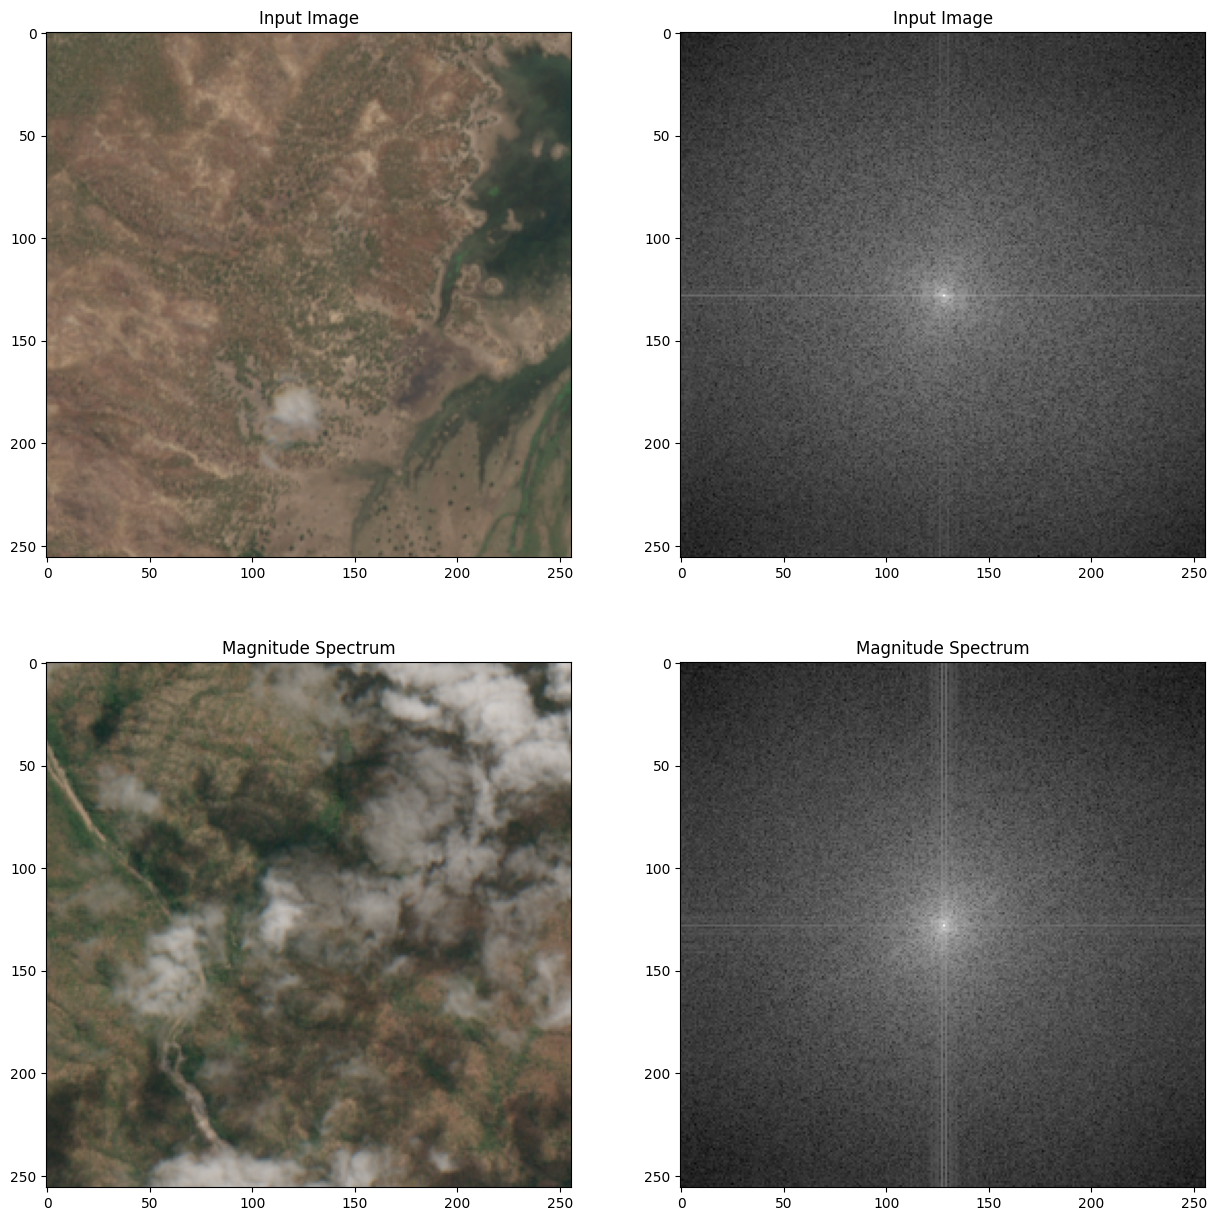

In [99]:
rgbs =extract_rgb(x_train[:2])
magnitude_spectrum = generate_magnitude_spectrum(x_train[:2])
display_list = [rgbs, magnitude_spectrum]
display_image(display_list, ["Input Image", "Magnitude Spectrum"])

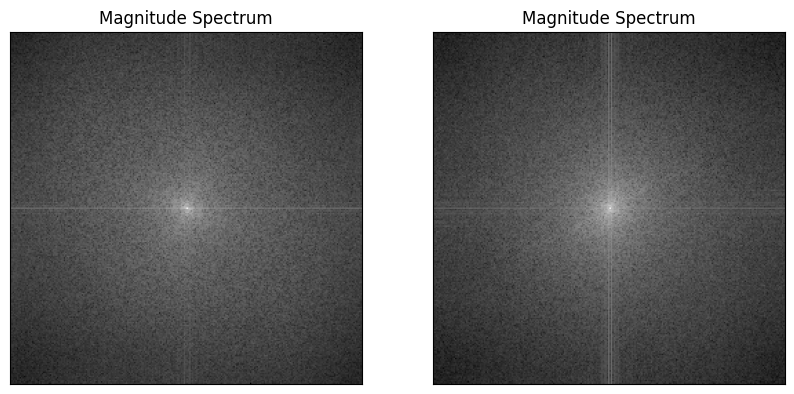

In [68]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(121),plt.imshow(magnitude_spectrum[0], cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum[1], cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()